In [2]:
import pandas as pd
import numpy as np


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [10]:
from imblearn.over_sampling import SMOTE

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

In [18]:
df = pd.read_csv("fraud.csv")

df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [20]:
df.shape


(6362620, 11)

In [22]:
df.info()
df.describe()
df['isFraud'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

In [24]:
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

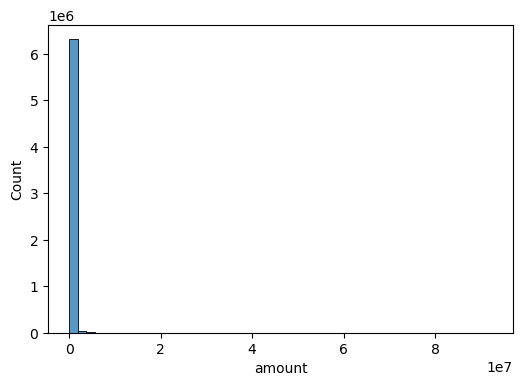

In [26]:
plt.figure(figsize=(6,4))
sns.histplot(df['amount'], bins=50)
plt.show()


In [28]:
df['log_amount'] = np.log1p(df['amount'])


In [32]:
df['orig_balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']


In [34]:
df.drop(columns=['nameOrig', 'nameDest'], inplace=True)


In [36]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)


In [38]:
X_temp = df.drop(columns=['isFraud'])
X_temp = X_temp.select_dtypes(include=[np.number])

vif_data = pd.DataFrame()
vif_data['feature'] = X_temp.columns
vif_data['VIF'] = [
    variance_inflation_factor(X_temp.values, i)
    for i in range(X_temp.shape[1])
]

vif_data.sort_values(by='VIF', ascending=False)


,feature,VIF
2,oldbalanceOrg,inf
4,oldbalanceDest,inf
5,newbalanceDest,inf
8,orig_balance_change,inf
9,dest_balance_change,inf
3,newbalanceOrig,1.532940e+08
1,amount,4.136186e+00
7,log_amount,4.128168e+00
0,step,3.674716e+00
6,isFlaggedFraud,1.000597e+00


In [39]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [40]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [41]:
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_scaled, y_train
)

pd.Series(y_train_resampled).value_counts()


isFraud
0    5083526
1    5083526
Name: count, dtype: int64

In [42]:
log_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

log_model.fit(X_train_resampled, y_train_resampled)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [45]:
y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))


              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1270881
           1       0.03      0.98      0.05      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.97      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524

ROC-AUC: 0.9952529932338076


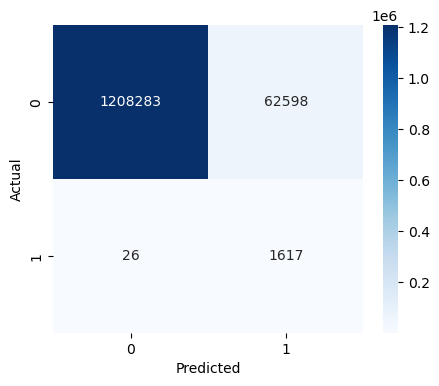

In [48]:
cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


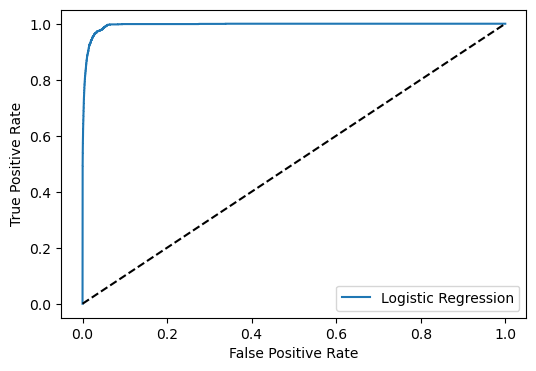

In [49]:
fpr, tpr, _ = roc_curve(y_test, y_prob_log)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [50]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=42)

In [55]:
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1270881
           1       0.11      0.99      0.19      1643

    accuracy                           0.99   1272524
   macro avg       0.55      0.99      0.59   1272524
weighted avg       1.00      0.99      0.99   1272524

ROC-AUC: 0.9994537267248212


In [56]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance.head(10)


,feature,importance
8,orig_balance_change,0.311665
2,oldbalanceOrg,0.135860
3,newbalanceOrig,0.106486
1,amount,0.085677
7,log_amount,0.081305
12,type_PAYMENT,0.058190
13,type_TRANSFER,0.056990
9,dest_balance_change,0.050991
0,step,0.043442
5,newbalanceDest,0.031377


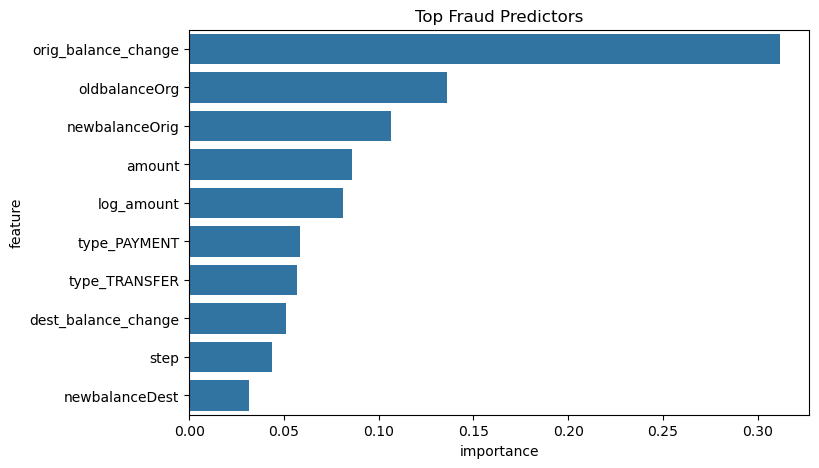

In [57]:
plt.figure(figsize=(8,5))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance.head(10)
)
plt.title("Top Fraud Predictors")
plt.show()
